# 3D Medical Image Analysis with PyTorch 

## Milestone 2

Datasets and Transforms


In [1]:
from typing import Callable, List, Optional, Tuple, Union

from glob import glob
import os
import random
import sys

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision.transforms import Compose

%matplotlib inline

%load_ext autoreload
%autoreload 2

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# RandomCrop3D


In [2]:
class RandomCrop3D:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size, output_size)
        else:
            assert len(output_size) == 3
            self.output_size = output_size
    
    def __call__(self, samples):
        assert isinstance(samples, (tuple))
        assert len(samples)==2
        src, target = samples
        
        h,w,l = src.shape
        hsize = self.output_size[0]
        wsize = self.output_size[1]
        lsize = self.output_size[2]
        
        lstart = np.random.randint(0, l-lsize+1)
        lend = lstart + lsize
        top = np.random.randint(0, h-hsize+1)
        bottom = top + hsize
        left = np.random.randint(0, w-wsize+1)
        right = left + wsize
        
        s = np.zeros((l, hsize, wsize))
        t = np.zeros((l, hsize, wsize))
        
        s = src[top:bottom, 
                left:right, 
                lstart:lend]
        t = target[top:bottom, 
                   left:right,
                   lstart:lend]
        rv = (torch.from_numpy(s), torch.from_numpy(t))        
        return rv

    



## Test RandomCrop3D

Image pairs should be corresponding 32x32 crops from the same source/target layers.  
Note that some target layers don't have full scan.

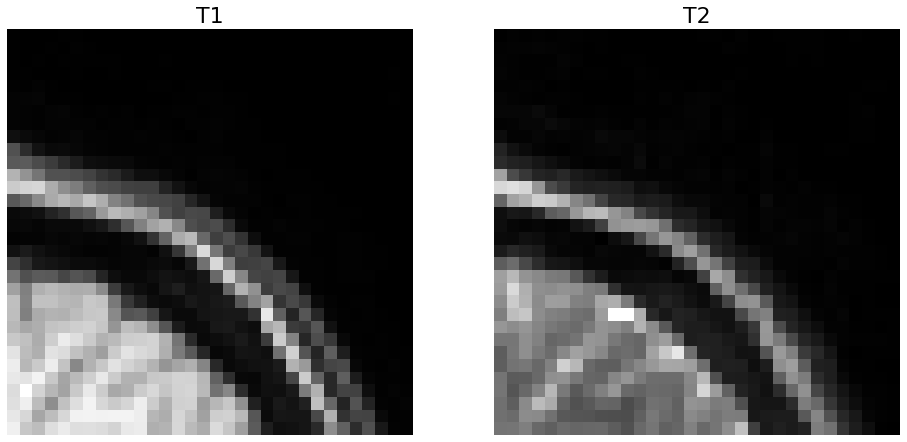

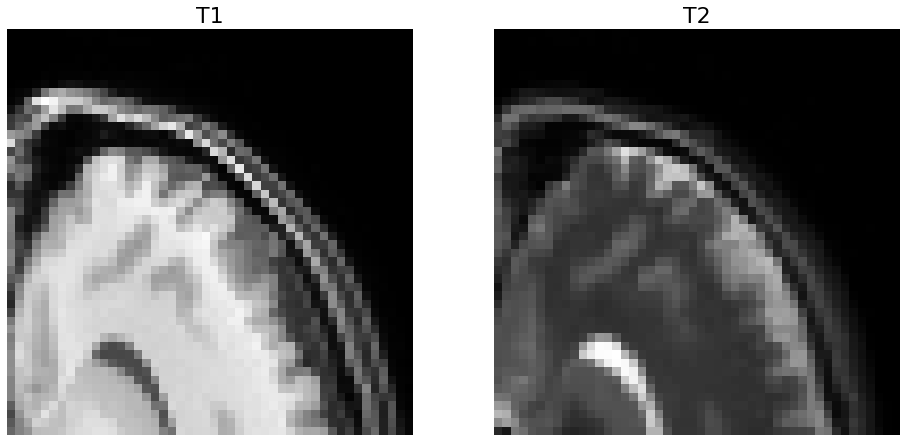

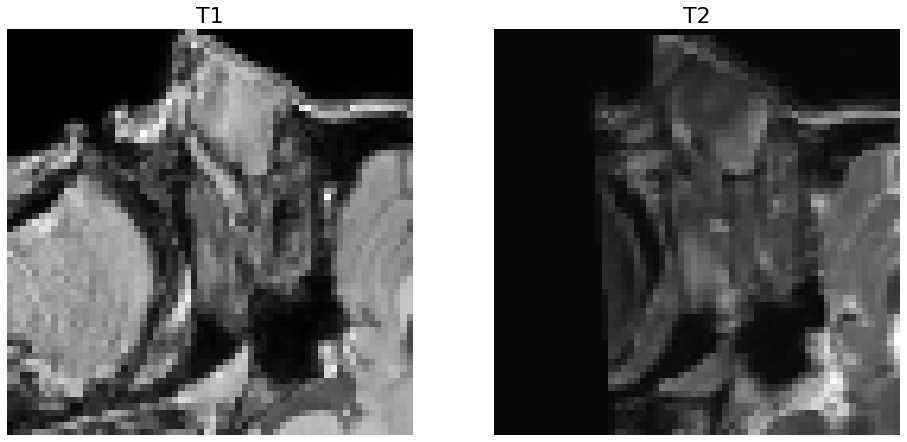

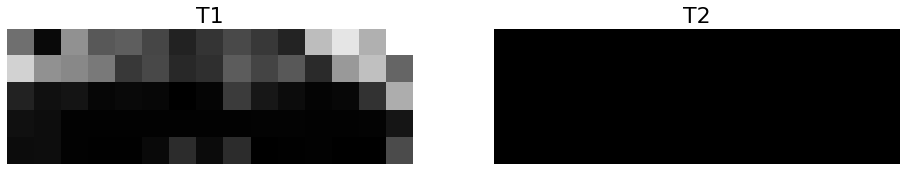

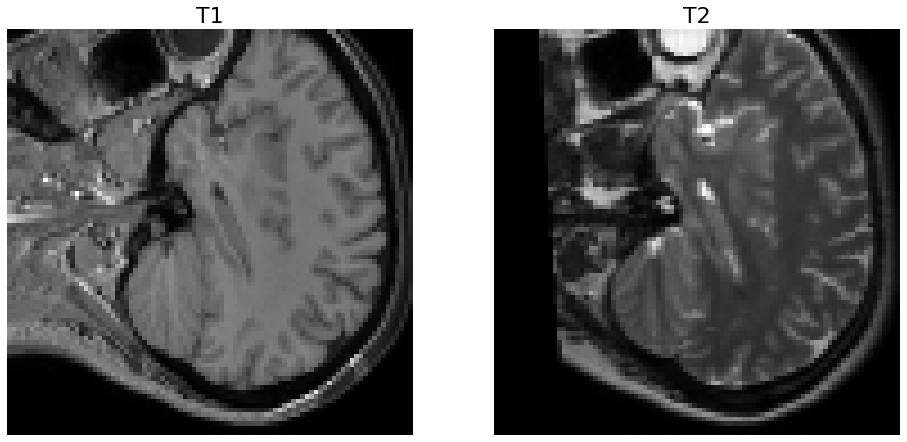

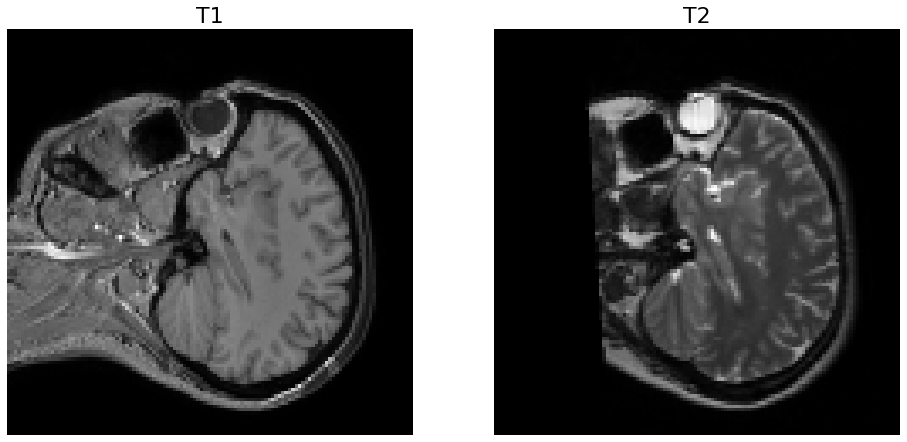

In [3]:
s = nib.load("small/t1/IXI102-HH-1416-T1_fcm.nii").get_fdata()
t = nib.load("small/t2/IXI102-HH-1416-T2_reg_fcm.nii").get_fdata()

def show_random_crop(n=32):
    crop = RandomCrop3D(n)
    ct1, ct2 = crop((s, t))

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,9))

    ax1.imshow(ct1[:,:,30], cmap='gray'); 
    ax2.imshow(ct2[:,:,30], cmap='gray'); 

    ax1.set_title('T1',fontsize=22); 
    ax1.axis('off'); 

    ax2.set_title('T2',fontsize=22); 
    ax2.axis('off');
    
show_random_crop()
show_random_crop(48)
show_random_crop(64)
show_random_crop((5, 15, 45)) 
show_random_crop(90) # Make sure we can output full width crop
show_random_crop((120, 120, 90)) 


# NiftiDataSet Class


In [4]:
from torch.utils.data.dataset import Dataset
from os import listdir
from os.path import isfile, join

class NiftiDataset(Dataset):
    def __init__(self, source_dir, target_dir, transform=None):
        self.source_files = [join(source_dir, f) for f in listdir(source_dir) if isfile(join(source_dir, f))]
        self.target_files = [join(target_dir, f) for f in listdir(target_dir) if isfile(join(target_dir, f))]
        self.transform = transform
        
    def __len__(self):
        return len(self.source_files)
    
    def __getitem__(self, idx):
        src = nib.load(self.source_files[idx]).get_fdata(dtype=np.float32)
        target = nib.load(self.target_files[idx]).get_fdata(dtype=np.float32)
        sample = (src, target)
        if self.transform:
            sample = self.transform(sample)
        return sample



## Test NiftiDataSet Class without transform

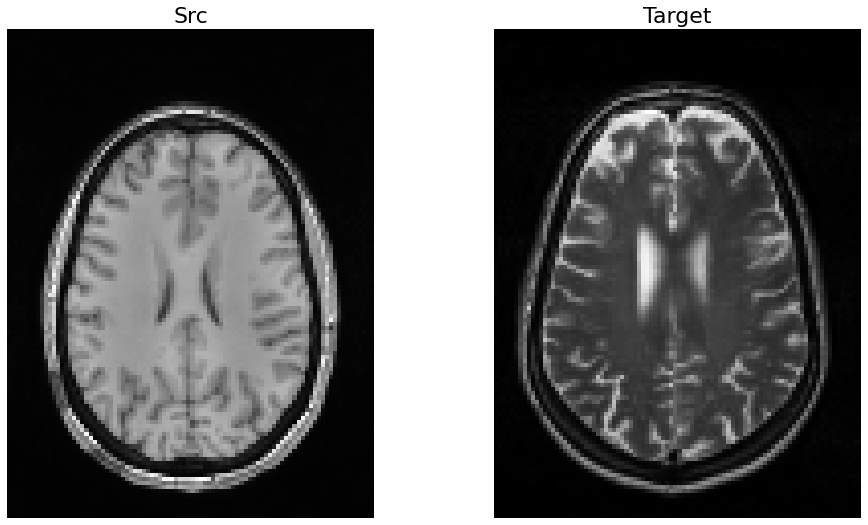

In [5]:
ds = NiftiDataset('small/t1', 'small/t2', None)
idx = np.random.randint(0, len(ds))

src, target = ds[idx]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,9))

ax1.imshow(src[:,80,:], cmap='gray'); 
ax2.imshow(target[:,80,:], cmap='gray'); 

ax1.set_title('Src',fontsize=22); 
ax1.axis('off'); 

ax2.set_title('Target',fontsize=22); 
ax2.axis('off');




## Test NiftiDataSet with RandomCrop3D transform

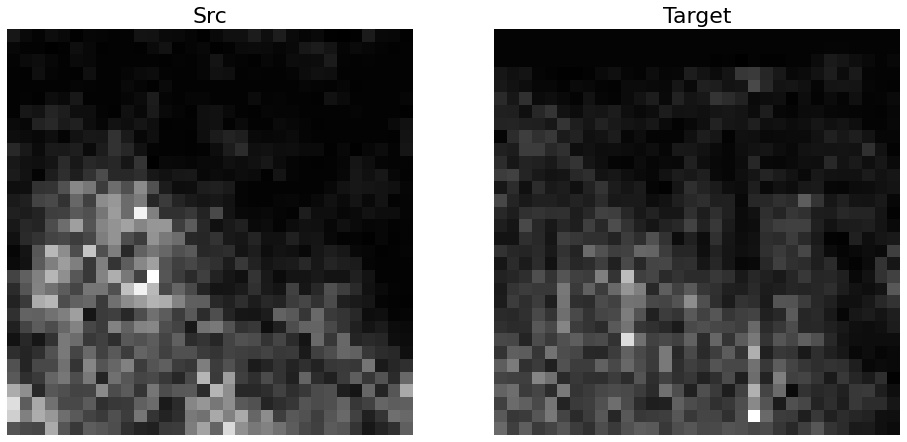

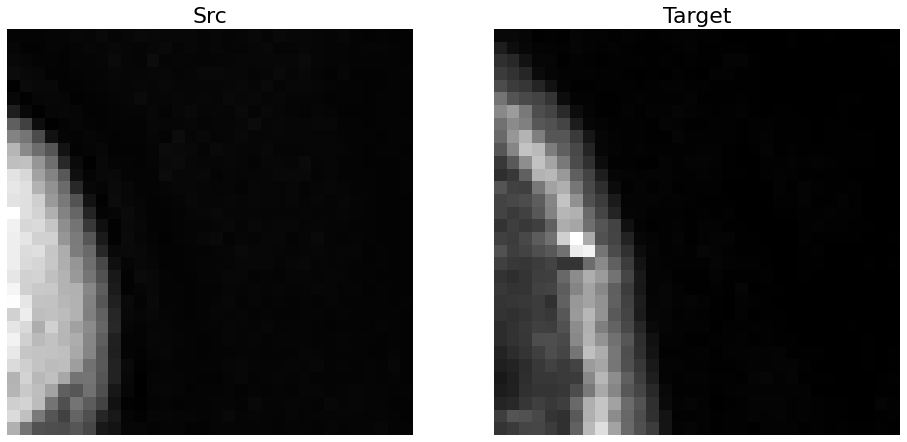

In [11]:
crop_transform = RandomCrop3D(32)

ds = NiftiDataset('small/t1', 'small/t2', crop_transform)

def get_random_crops():
    idx = np.random.randint(0, len(ds))

    src, target = ds[idx]

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,9))

    ax1.imshow(src[:,:,30], cmap='gray'); 
    ax2.imshow(target[:,:,30], cmap='gray'); 

    ax1.set_title('Src',fontsize=22); 
    ax1.axis('off'); 

    ax2.set_title('Target',fontsize=22); 
    ax2.axis('off');

get_random_crops()
get_random_crops()
plt.show()